# New York City AirBnB Data Modeling and Analysis

Made for the University of San Diego
Course: AAI-510 (Machine learning: Fundamentals and Applications)
Professor: Wesley Pasfield, MS

By - Doug Code (dcode15), Subhabrata Ganguli (suvoganguli), Jeffrey Lehrer (J-Lehrer)

# Problem statement and justification for the proposed approach.


As with any business, one of the primary goals is to increase revenue. Depending on the business there are many avenues to pursue to reach this goal. In the case of Airbnb, one of the ways to increase the revenue is to have more people use the service and a second is to have them pay an optimal price. There are a few ways to accomplish these tasks and some of them will be covered in this notebook. 

Since Airbnb is a business whose profits are a portion of the sales of the individual hosts who work under their label, the higher price a host can charge and still get a customer the better it will be for both the host and Airbnb. Meaning that if similar locations are charging more for a room with the same number of beds and amenities then both the host and Airbnb could be making more if that location were to charge more. 

For any given customer in a given location there is a maximum price that customer will be willing to pay. Since it would be very difficult to determine the optimum price for each individual customer, the better option is to find the best price point for each location based on its coordinates and amenities. It should be noted that there are probably some better optimizations for location based pricing if considering proximity to major attractions and amenities in the city. For this notebook neighborhood and GPS coordinate were considered. As far as amenities goes, generally if a location has more bedrooms and bathrooms available the higher the price will be, however, there are many other types of amenities to consider when booking an Airbnb and the website does its best to let the customer know which ones will be available at a given location. These include things like whether or not the accommodation has a microwave, minifridge, full kitchen or no cooking appliances at all. Additionally things like washers, dryers and air conditioners are also included in the descriptions. There are some locations that will list that they are close to bars or specific attractions in the area but as previously stated, those specifics will be outside of the scope of this investigation.  

To find an optimal price the number of features used in the model will have to be considered. The dataset used for this notebook has many features, including information about the host of the specific Airbnb. Some of these features may be helpful while others most likely will not. A good example of this is host response rate and host response time, correlating to the percentage of offers for the Airbnb that the host responds to and the average amount of time that it takes that host to respond respectively. Some less helpful features in the dataset include calculated host listings counts for total available rentals, entire homes, private rooms and shared rooms. Most hosts only have one property available for rent meaning that most of the other categories for listing will be zero. 

To begin, this notebook will visualize several of the features to get an idea of their distribution and range. Then it will perform some clean up on several of the features that are considered to be useful. This will be done through various feature engineering techniques like median, one-hot encoding, as well as label and frequency encoding. The primary purpose of this will be to ease the model production process. Then several different modeling techniques will be used on the modified data and the models will be evaluated on the same metrics to see which one will be selected for deployment. 

## Introduction

Airbnb, an online marketplace for lodging, has transformed the way people travel and find accommodations. In major cities like New York City, Airbnb listings provide a wide variety of options for travelers, ranging from entire apartments and homes to private rooms in shared apartments. This flexibility has made Airbnb a popular choice among both tourists and business travelers.

In this notebook, we will explore the Airbnb dataset for New York City. This dataset provides detailed information on listings available on Airbnb, including prices, locations, types of properties, and reviews. By analyzing this data, we can gain insights into the rental market in New York City, understand pricing strategies, identify popular neighborhoods, and much more.

## Dataset Description

The dataset used in this analysis is obtained from [Inside Airbnb](http://insideairbnb.com/get-the-data.html), a website that provides publicly available data on Airbnb listings. 

## Objectives

In this analysis, the business needs are to achieve the following objectives:

1. **Data Exploration**: Understand the structure and contents of the dataset through summary statistics and visualizations.
2. **Price Analysis**: Analyze the pricing strategies of different types of listings and identify factors influencing prices.
3. **Geographical Analysis**: Examine the geographical distribution of listings and identify popular neighborhoods.
4. **Regression Analysis**: Predict the price of listing based on the test data


In [27]:
import optuna
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

from evaluation.ModelEvaluator import ModelEvaluator
from preprocessing.ColumnEncoder import ColumnEncoder
from preprocessing.ColumnSelector import ColumnSelector
from preprocessing.DataCleaner import DataCleaner
from preprocessing.DataImputer import DataImputer
from tuners.GradientBoostingRegressorTuner import GradientBoostingRegressorTuner
from tuners.HistGradientBoostingRegressorTuner import HistGradientBoostingRegressorTuner
from tuners.RandomForestRegressorTuner import RandomForestRegressorTuner
from tuners.XGBRegressorTuner import XGBRegressorTuner

# Data understanding (EDA) – a graphical and non-graphical representation of relationships between the response variable and predictor variables.


As far as data is concerned, if there is a choice between quantity and quality, quality is preferred but it is ideal to have both. With the dataset used for this notebook the majority of the data is clean and usable fresh from the source. There are very few null values in the dataset and most of the data is stored as numbers. The exception to the cleanliness and usability of the data being that some of the features include symbols (most notably the ‘$’ character is included in price) and other features are categorical which require encoding to be interpreted by the model. There are also some features which are not useful which will have to be removed like the ‘listing_url’, ‘picture_url’, ‘host_id’, ‘id’, ‘last_scraped’, and ‘source’. Other features may have some relevance but it is unlikely that they will have more of a noticeable influence than other features like ‘calculated_host_listings_count’ and the other calculated_host_listing_count of the various property types.

In [3]:
# Read data

df = pd.read_csv("../data/listings-full.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,30314819,https://www.airbnb.com/rooms/30314819,20240406173624,2024-04-07,previous scrape,Brooklyn Finest Air Bnb,THE GUEST'S WILL HAVE ACCESS TO LOTS OF RESTAU...,NaN,https://a0.muscache.com/pictures/1ababa1b-a7d1...,224699779,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
1,30391955,https://www.airbnb.com/rooms/30391955,20240406173624,2024-04-07,previous scrape,Queens Comfort,Quiet neighborhood with plenty of on street pa...,10 min walk to Sutphin Av Archer Av Station wh...,https://a0.muscache.com/pictures/8d63479f-f4b6...,228213504,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
2,30378211,https://www.airbnb.com/rooms/30378211,20240406173624,2024-04-07,previous scrape,Shared Studio (females only),Bunk bed is shared with 1 other roommate (fema...,NaN,https://a0.muscache.com/pictures/500a4692-45da...,200401254,...,NaN,NaN,NaN,NaN,f,1,0,0,1,NaN
3,30459160,https://www.airbnb.com/rooms/30459160,20240406173624,2024-04-07,previous scrape,Large 2 Bedroom Apt - Close to everything!,Welcome to my massive two bedroom apt in eleva...,NaN,https://a0.muscache.com/pictures/a28e27f9-2360...,84147508,...,5.0,5.0,5.0,NaN,f,1,1,0,0,0.02
4,30746536,https://www.airbnb.com/rooms/30746536,20240406173624,2024-04-07,previous scrape,Stylish Single Room in Hell’s Kitchen,NaN,NaN,https://a0.muscache.com/pictures/6879386e-5133...,20416352,...,5.0,5.0,3.0,NaN,f,1,0,1,0,0.02


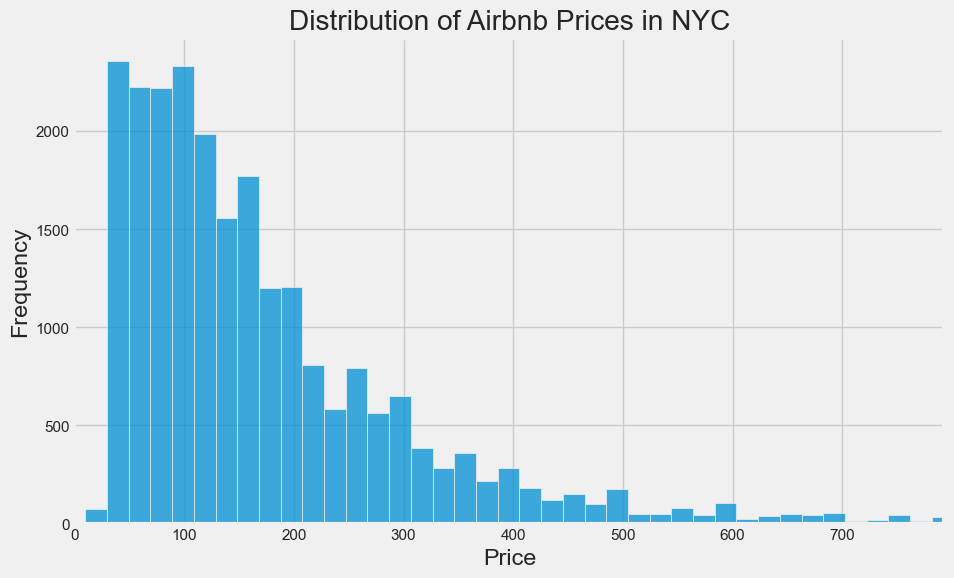

In [4]:
df['price'] = df['price'].str.replace('$', '', regex=False).replace('None', None).replace('', None)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Set styles for the plots
sns.set(style="whitegrid")
plt.style.use("fivethirtyeight")

# Histogram for price
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=False)
plt.title('Distribution of Airbnb Prices in NYC')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, df['price'].quantile(0.99))  # To limit the x-axis to the 99th percentile to avoid extreme outliers
plt.show()

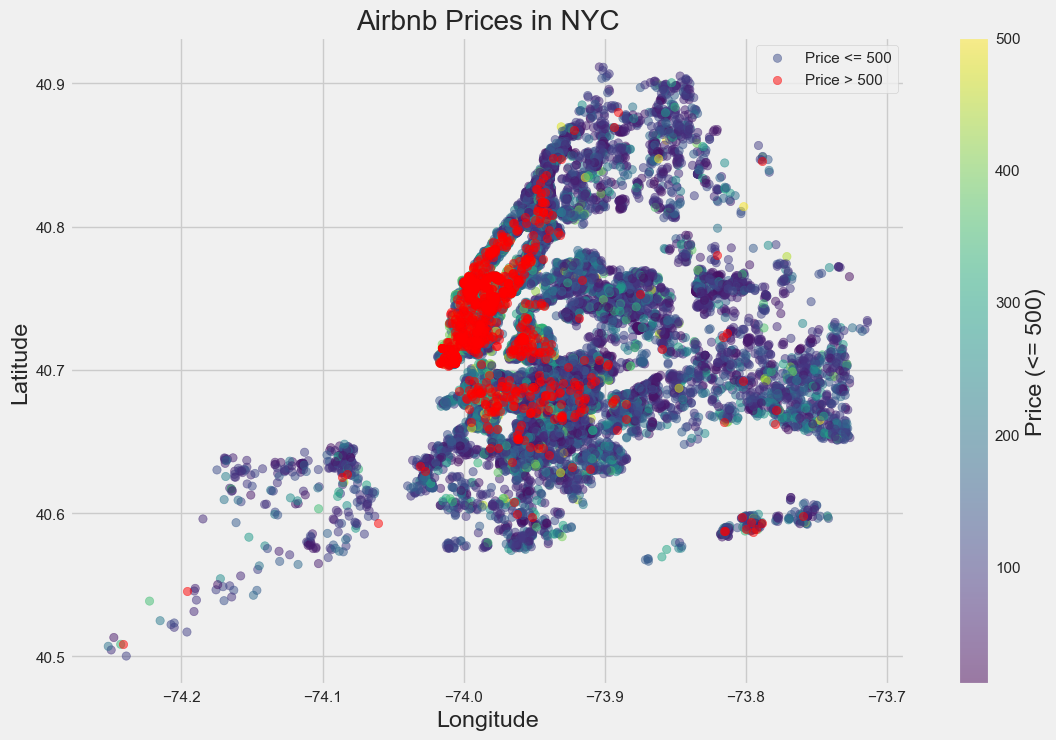

In [5]:
# Split the data into two groups
df_below_500 = df[df['price'] <= 500]
df_above_500 = df[df['price'] > 500]

# Plot the data
plt.figure(figsize=(12, 8))

# Scatter plot for prices <= 500
sc = plt.scatter(df_below_500['longitude'], df_below_500['latitude'], c=df_below_500['price'], cmap='viridis', alpha=0.5, label='Price <= 500')

# Scatter plot for prices > 1000
plt.scatter(df_above_500['longitude'], df_above_500['latitude'], color='red', alpha=0.5, label='Price > 500')

# Add color bar for the price <= 1000 points
cbar = plt.colorbar(sc, label='Price (<= 500)')

# Add titles and labels
plt.title('Airbnb Prices in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

/var/folders/d7/3y4pn1x55_583bts49jyqlxh0000gn/T/ipykernel_66552/755991337.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


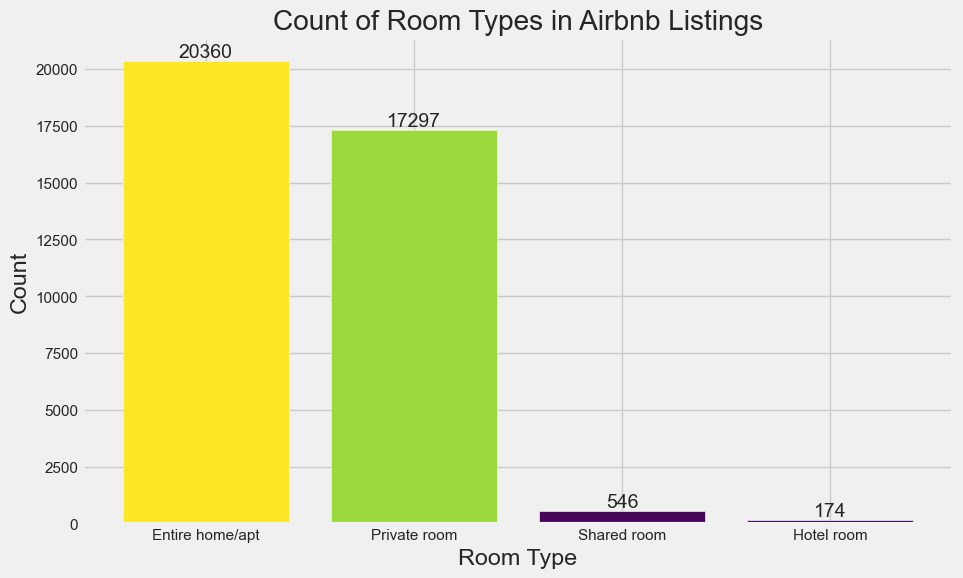

In [6]:
# Count the occurrences of each room type
room_type_counts = df['room_type'].value_counts()

# Get the viridis colormap
cmap = cm.get_cmap('viridis')

# Normalize the color range
norm = plt.Normalize(room_type_counts.min(), room_type_counts.max())
colors = cmap(norm(room_type_counts.values))

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(room_type_counts.index, room_type_counts.values, color=colors)

# Add titles and labels
plt.title('Count of Room Types in Airbnb Listings')
plt.xlabel('Room Type')
plt.ylabel('Count')

# Add value labels on the bars
for index, value in enumerate(room_type_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

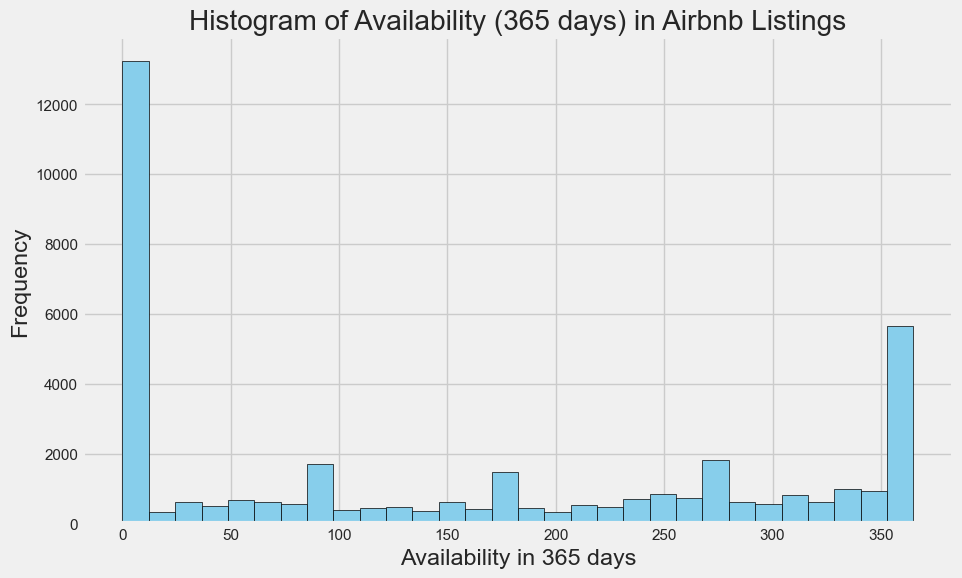

In [7]:
# Plot the histogram for availability_365
plt.figure(figsize=(10, 6))
plt.hist(df['availability_365'], bins=30, edgecolor='black', color='skyblue')

# Add titles and labels
plt.title('Histogram of Availability (365 days) in Airbnb Listings')
plt.xlabel('Availability in 365 days')
plt.ylabel('Frequency')

plt.show()

## Boxplots for categorical features

The following plots show that there are several outliers corresponding to high price values. This can mean that we will not get a high R^2 score for regression since the variance of the price data is high.

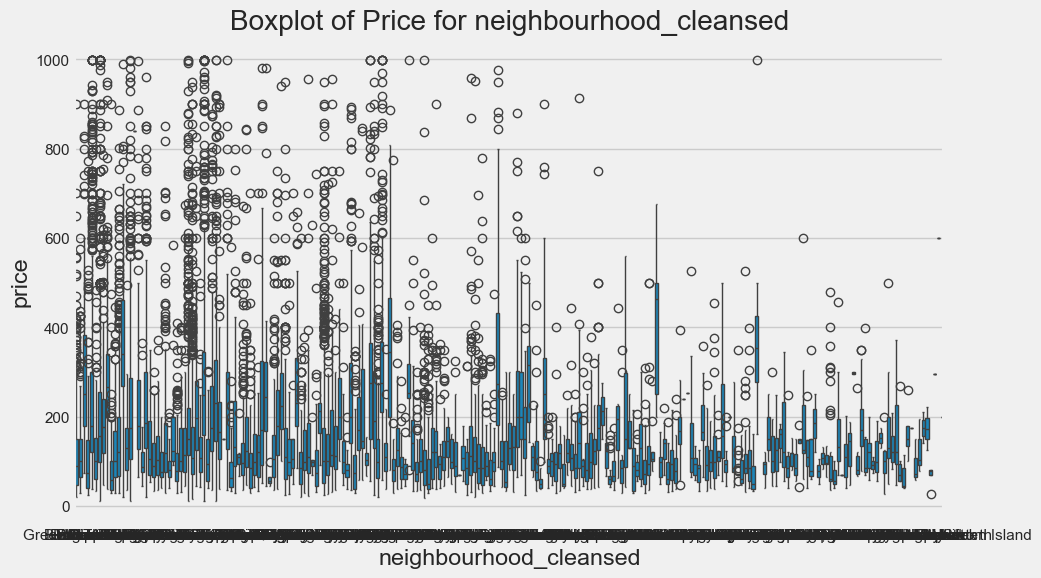

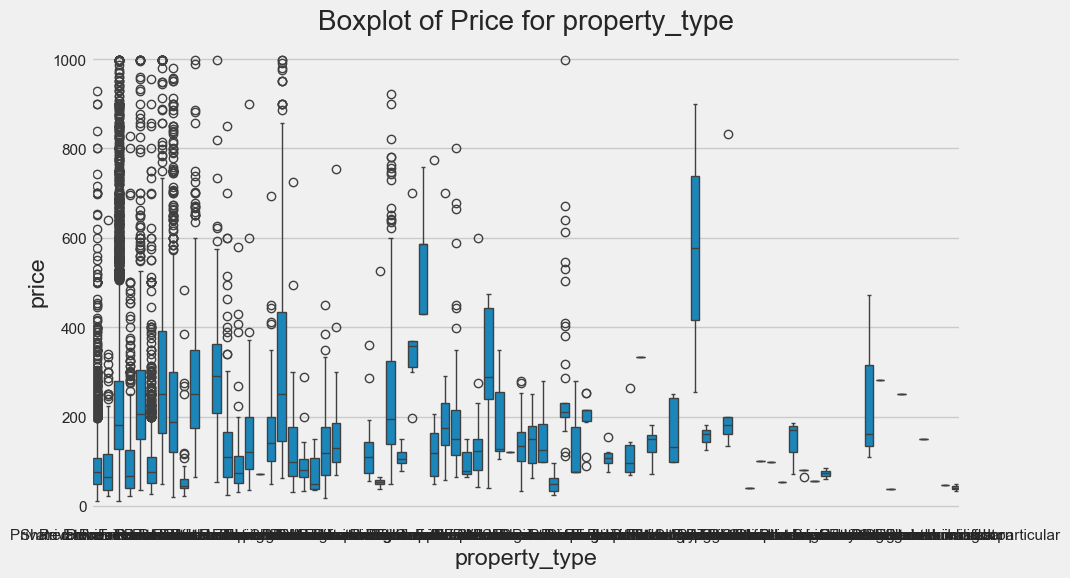

In [45]:
# Select the columns for train and test datasets
xy_train = df.copy()
xy_test = df.copy()

# Remove % sign and convert to numeric
xy_train['host_response_rate'] = xy_train['host_response_rate'].str.rstrip('%').astype('float') / 100
xy_train['host_acceptance_rate'] = xy_train['host_acceptance_rate'].str.rstrip('%').astype('float') / 100
xy_test['host_response_rate'] = xy_test['host_response_rate'].str.rstrip('%').astype('float') / 100
xy_test['host_acceptance_rate'] = xy_test['host_acceptance_rate'].str.rstrip('%').astype('float') / 100

# Identifying categorical features
categorical_features = xy_train.select_dtypes(include=['object']).columns

# Plotting boxplots for each categorical feature against price
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='price', data=xy_train)
    plt.title(f'Boxplot of Price for {feature}')
    plt.show()

# Data Preparation

To prepare the data for feature engineering, the following tasks were carried out:
* Non-training features like image urls were removed from the data
* Features that had formatting which prevented them from being properly typed by pands, like features with "$" or "%" signs in them were converted to the appropriate data type.
* A set of additional location-based features were created. These features are prefixed with "dist_", and measure the AirBnBs geographic distance from a number of key attractions around New York City. This allows the model to adjust prices for rentals near major tourist centers.
* All amenities listed on all listings were aggregated and counted. To prevent a very large number of additional features from more obscure amenities, the top 50 most common amenities were added as boolean features with prefix "amenity_".

In [3]:
# Perform initial data cleaning
data_path: str = "../data/listings-full.csv"
data: pd.DataFrame = pd.read_csv(data_path)
data = DataCleaner.perform_base_cleaning(data)
data = DataImputer.remove_outliers_iqr(data, ["price"])

# Feature Engineering

A mixture of median, on-hot, label and frequency encoding were used based on a mixture of analyzing each categorical feature and model-based experimentation. For example, the `host_response_time` feature has inherent cardinality so label encoding was used.

In [4]:
# Encode categorical columns
median_encode_columns = ['neighbourhood_cleansed']
one_hot_columns = ['neighbourhood_group_cleansed', 'property_type']
label_encode_columns = ['host_response_time']
frequency_encode_columns = ['room_type']

data = ColumnEncoder.one_hot_encode_columns(data, one_hot_columns)
data = ColumnEncoder.label_encode_columns(data, label_encode_columns)

train_data, val_data, test_data = DataCleaner.split_train_val_test(data)

train_data = ColumnEncoder.median_encode_columns(train_data, median_encode_columns, "price")
val_data = ColumnEncoder.median_encode_columns(val_data, median_encode_columns, "price")
test_data = ColumnEncoder.median_encode_columns(test_data, median_encode_columns, "price")

train_data = ColumnEncoder.frequency_encode_columns(train_data, frequency_encode_columns)
val_data = ColumnEncoder.frequency_encode_columns(val_data, frequency_encode_columns)
test_data = ColumnEncoder.frequency_encode_columns(test_data, frequency_encode_columns)

Mean, median, most frequent, and constant imputation were used for missing values. Columns were again assigned to each technique based on a mixture of analysis and model-based experimentation. Due to the relatively large number of columns that needed to be imputed, this process relied more on automated experimentation than the encoding process. In the automated experimentation, models were generated using different imputation methods for each column and results were compared to find the most effective method.

In [5]:
# Impute missing values
mean_impute_columns = ['host_listings_count', 'room_type', 'accommodates', 'minimum_nights', 'maximum_minimum_nights',
                       'minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm',
                       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'calculated_host_listings_count',
                       'dist_empire_state_building', 'dist_laguardia']
most_frequent_impute_columns = ['host_response_time', 'host_is_superhost', 'minimum_nights_avg_ntm', 'availability_60',
                                'availability_365', 'calculated_host_listings_count_shared_rooms', 'dist_high_line',
                                'dist_st_georges_theatre']
constant_impute_columns = ['neighbourhood_cleansed', 'maximum_nights', 'minimum_minimum_nights', 'availability_90',
                           'number_of_reviews', 'dist_central_park', 'dist_brooklyn_bridge']

train_data = DataImputer.impute_missing_values(train_data, mean_impute_columns, SimpleImputer(strategy="mean"))
val_data = DataImputer.impute_missing_values(val_data, mean_impute_columns, SimpleImputer(strategy="mean"))
test_data = DataImputer.impute_missing_values(test_data, mean_impute_columns, SimpleImputer(strategy="mean"))

train_data = DataImputer.impute_missing_values(train_data, most_frequent_impute_columns,
                                               SimpleImputer(strategy="most_frequent"))
val_data = DataImputer.impute_missing_values(val_data, most_frequent_impute_columns,
                                             SimpleImputer(strategy="most_frequent"))
test_data = DataImputer.impute_missing_values(test_data, most_frequent_impute_columns,
                                              SimpleImputer(strategy="most_frequent"))

train_data = DataImputer.impute_missing_values(train_data, constant_impute_columns,
                                               SimpleImputer(strategy="constant", fill_value=-9999))
val_data = DataImputer.impute_missing_values(val_data, constant_impute_columns,
                                             SimpleImputer(strategy="constant", fill_value=-9999))
test_data = DataImputer.impute_missing_values(test_data, constant_impute_columns,
                                              SimpleImputer(strategy="constant", fill_value=-9999))

train_data = DataImputer.impute_missing_values(train_data, data.columns, SimpleImputer(strategy="median"))
val_data = DataImputer.impute_missing_values(val_data, data.columns, SimpleImputer(strategy="median"))
test_data = DataImputer.impute_missing_values(test_data, data.columns, SimpleImputer(strategy="median"))

x_train, y_train, x_val, y_val, x_test, y_test = DataCleaner.perform_x_y_split(train_data, val_data, test_data)

print(f"Training data contains {len(train_data)} records.")
print(f"Validation data contains {len(val_data)} records.")
print(f"Testing data contains {len(test_data)} records.")

Training data contains 13363 records.
Validation data contains 4455 records.
Testing data contains 4455 records.


To decided on an ideal number of features, models were trained with different numbers of features ranging from 5 to 170. In each run, features were removed using recursive feature elimination until the desired feature count was achieved. Due to the amount of computation time required for this, the process was run once outside the Jupyter Notebook to collect the data shown here.

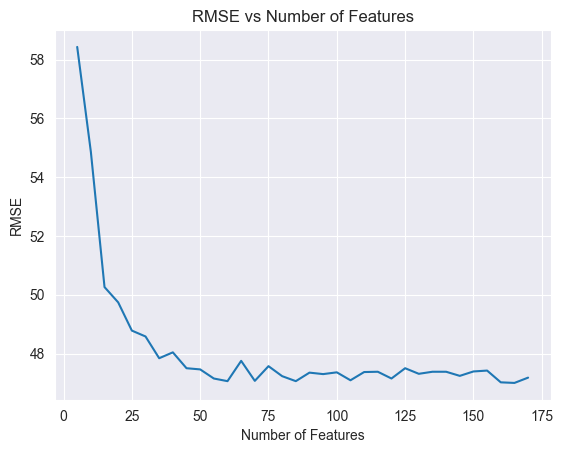

In [6]:
# Plot number of features in model vs RMSE
n_features_rmse = {5: 58.43, 10: 54.86, 15: 50.26, 20: 49.74, 25: 48.78, 30: 48.58, 35: 47.84, 40: 48.04, 45: 47.50, 50: 47.46, 55: 47.15, 60: 47.06, 65: 47.75, 70: 47.07, 75: 47.57, 80: 47.23, 85: 47.06, 90: 47.35, 95: 47.30, 100: 47.36, 105: 47.09, 110: 47.37, 115: 47.38, 120: 47.15, 125: 47.50, 130: 47.31, 135: 47.38, 140: 47.38, 145: 47.24, 150: 47.39, 155: 47.42, 160: 47.02, 165: 47.00, 170: 47.18}

features = list(n_features_rmse.keys())
rmses = list(n_features_rmse.values())

plt.plot(features, rmses)
plt.title('RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.show()

Based on the results shown above, the performance of the model increased consistently until 60 features, then leveled off with further feature additions. Based on this, 60 was chosen as the optimal number of features to include to minimize dimensionality while maximizing performance.

Using recursive feature elimination, the number of features in the dataset was decreased from 174 to 60. Examining the chosen features shows a wide range of feature types contributing to the model, including host information, rental size, rental availability, reviews, and room type. A number of the engineered amenity and location-distance features were also included.

In [7]:
# Use recursive feature elimination for feature selection
n_features = 60
top_columns = ColumnSelector.recursive_feature_elimination(x_train, y_train, n_features)
print(f"Top columns: {top_columns}")

x_train = x_train[top_columns]
x_val = x_val[top_columns]
x_test = x_test[top_columns]

Top columns: ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'longitude', 'dist_times_square', 'dist_central_park', 'dist_empire_state_building', 'dist_statue_of_liberty', 'dist_brooklyn_bridge', 'dist_high_line', 'dist_gantry_plaza', 'amenity_ha

# Modeling

The final modeling phase focused on four tree-based ensemble algorithms: Gradient Boosting, Extreme Gradient Boosting (XGBoost), Histogram Gradient Boosting (LightGBM), and Random Forest. These algorithms were chosen to due to their natural handling of outliers and various scales, and ability to capture non-linear relationships. They also have built-in measures of feature importance, which allowed much easier feature selection given the short project timeline and relatively large number of initial features.

Initial exploration also considered Linear Regression and Support Vector Regression. However, the linear model failed to capture the more complex non-linear relationships in the data and performed poorly, while the SVR model performed somewhat better but was very slow to train on a dataset of this size and underperformed compared to the tree-based models.

All models were tuned with the Optuna library using a Tree-structured Parzen Estimator (TPE) tuner. TPE is a Bayesian approach that initially takes a random sample from the hyperparameter space and uses the results to form a probabilistic model of how effective or ineffective a set of hyperparameters might be. It then tries to balance exploration of new areas of the hyperparameter space against exploitation of areas that are known to achieve strong results. Using this approach was especially helpful given our limited compute resources, as it can often converge on a high-performing combination of hyperparameters much more quickly than a simple grid or random search. All models used the same tuner and 100 trials for their hyperparameter tuning.

## Histogram Gradient Boosting Regression

In [7]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [8]:
# Tune histogram gradient boosting regressor hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(HistGradientBoostingRegressorTuner.tune(x_train, y_train, x_val, y_val), n_trials=100)
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'learning_rate': 0.10843781383787221, 'max_iter': 324, 'max_depth': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.44070390480011, 'max_leaf_nodes': 172, 'max_bins': 254, 'early_stopping': True, 'validation_fraction': 0.1594203268181018, 'tol': 0.0007295260718517506}


In [9]:
# Train histogram gradient boosting regressor model
hist_gbr_model = HistGradientBoostingRegressor(**study.best_params, random_state=1).fit(x_train, y_train)

{'mse': 2451.6324127017765, 'rmse': 49.513961795656954, 'mae': 33.514247154517186}


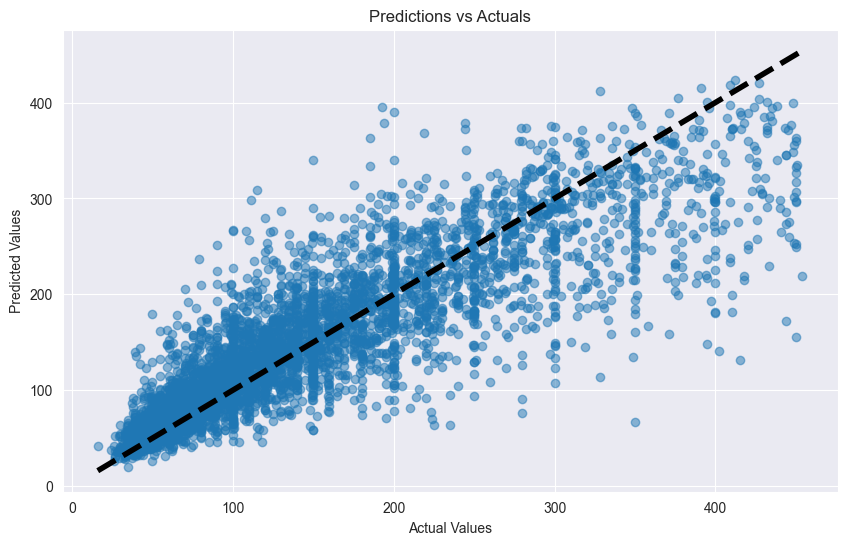

In [10]:
# Test histogram gradient boosting regressor model
hist_gbr_preds = hist_gbr_model.predict(x_test)
hist_gbr_metrics = ModelEvaluator.get_key_metrics(y_test, hist_gbr_preds)
print(hist_gbr_metrics)
ModelEvaluator.plot_predictions_vs_actuals(y_test, hist_gbr_preds)

## Random Forest Regressor

In [11]:
# Tune random forest regressor hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(RandomForestRegressorTuner.tune(x_train, y_train, x_val, y_val), n_trials=100)
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'n_estimators': 177, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


In [12]:
# Train random forest boosting regressor model
rf_model = RandomForestRegressor(**study.best_params, random_state=1).fit(x_train, y_train)

{'mse': 2491.796654390119, 'rmse': 49.91789913838641, 'mae': 33.867149085426256}


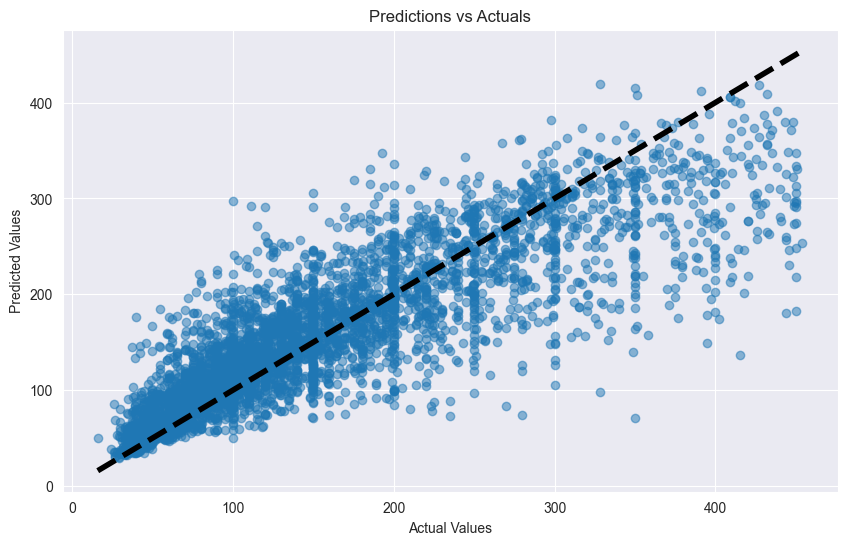

In [13]:
# Test random forest regressor model
rf_preds = rf_model.predict(x_test)
rf_metrics = ModelEvaluator.get_key_metrics(y_test, rf_preds)
print(rf_metrics)
ModelEvaluator.plot_predictions_vs_actuals(y_test, rf_preds)

## Gradient Boosting Regressor Algorithm

In [14]:
# Tune gradient boosting regressor hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(GradientBoostingRegressorTuner.tune(x_train, y_train, x_val, y_val), n_trials=100)
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'n_estimators': 276, 'learning_rate': 0.037797462675686185, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9380943696443256, 'max_features': 'log2'}


In [15]:
# Train gradient boosting regressor model
gbr_model = GradientBoostingRegressor(**study.best_params, random_state=1).fit(x_train, y_train)

{'mse': 2300.891032437831, 'rmse': 47.96760398891976, 'mae': 32.334842620057984}


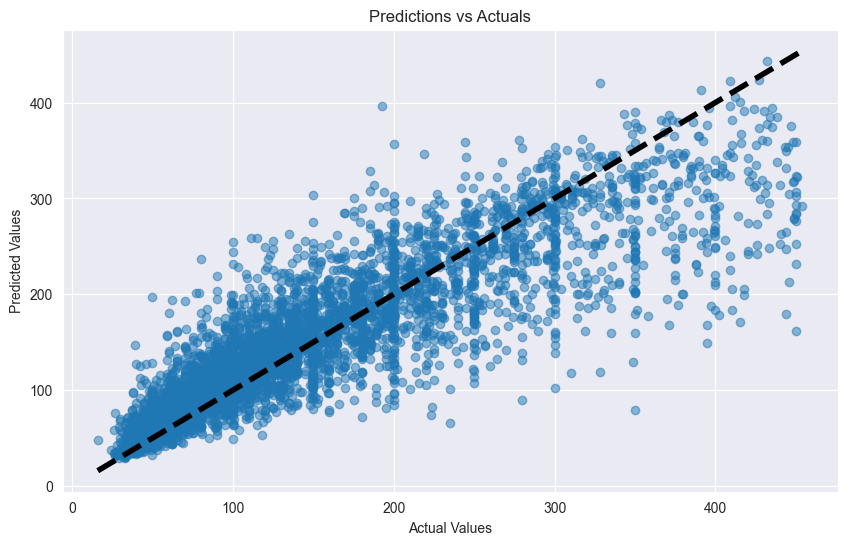

In [16]:
# Test gradient boosting regressor model
gbr_preds = gbr_model.predict(x_test)
gbr_metrics = ModelEvaluator.get_key_metrics(y_test, gbr_preds)
print(gbr_metrics)
ModelEvaluator.plot_predictions_vs_actuals(y_test, gbr_preds)

## Extreme Gradient Boosting Regressor Algorithm

In [17]:
# Tune extreme gradient boosting regressor hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(XGBRegressorTuner.tune(x_train, y_train, x_val, y_val), n_trials=100)
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'n_estimators': 280, 'learning_rate': 0.0893511928305622, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.12817825328271884, 'subsample': 0.5007138526715688, 'colsample_bytree': 0.5210242609214725, 'reg_alpha': 0.8902186308454083, 'reg_lambda': 0.4807324151988472}


In [18]:
# Train extreme gradient boosting regressor model
xgbr_model = XGBRegressor(**study.best_params, random_state=1).fit(x_train, y_train)

{'mse': 2478.0482351355713, 'rmse': 49.77999834406959, 'mae': 33.906529487798245}


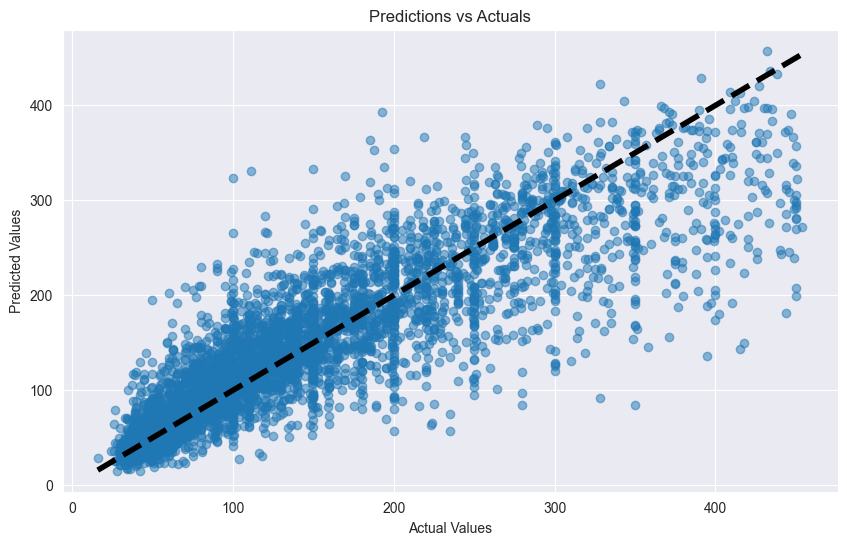

In [19]:
# Test extreme gradient boosting regressor model
xgbr_preds = xgbr_model.predict(x_test)
xgbr_metrics = ModelEvaluator.get_key_metrics(y_test, xgbr_preds)
print(xgbr_metrics)
ModelEvaluator.plot_predictions_vs_actuals(y_test, xgbr_preds)

# Model Evaluation

To compare models, the root mean squared error and mean absolute error were graphed for each model. Since the difference between the metrics for these models was quite small compared to the scale of the values, each was graphed relative to the average across all four models to make the differences more clear.

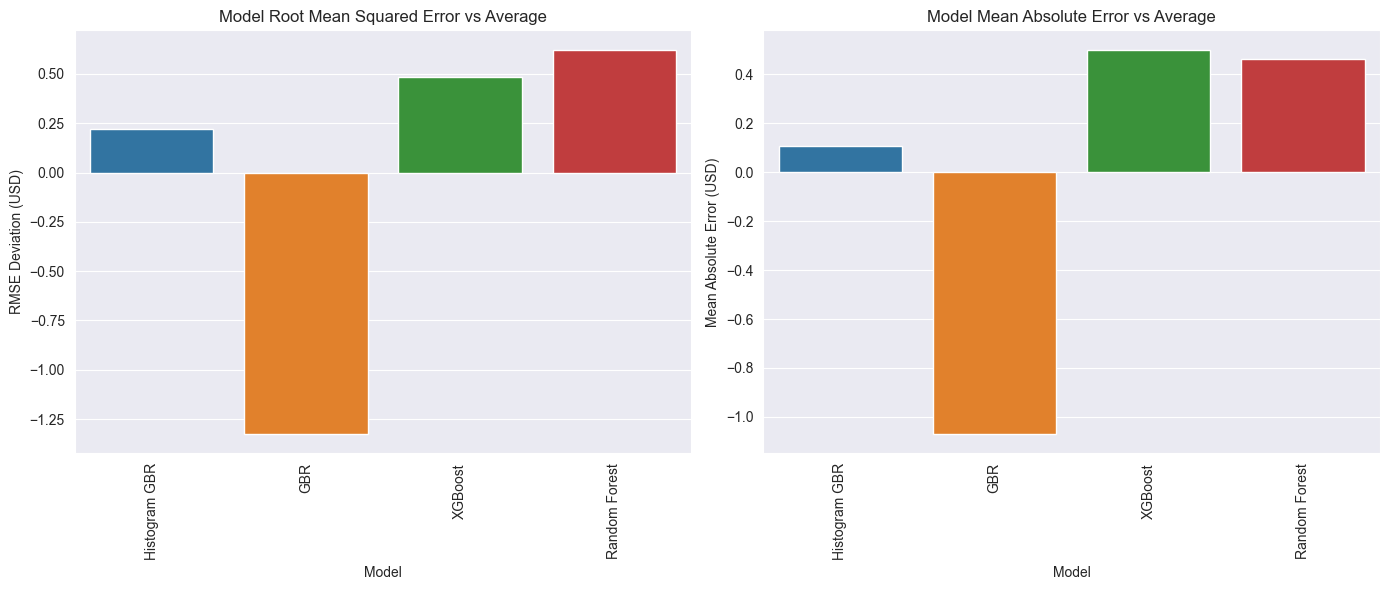

In [48]:
# Plot RMSE and MAE deviation from average for each model
model_metrics = pd.DataFrame({
    'Model': ['Histogram GBR', 'GBR', 'XGBoost',
                  'Random Forest'],
    'RMSE': [hist_gbr_metrics["rmse"],gbr_metrics["rmse"], xgbr_metrics["rmse"], rf_metrics["rmse"]],
    'MAE': [hist_gbr_metrics["mae"], gbr_metrics["mae"], xgbr_metrics["mae"], rf_metrics["mae"]]
})
model_metrics["RMSE_Dev"] = model_metrics["RMSE"] - model_metrics[["RMSE"]].mean()["RMSE"]
model_metrics["MAE_Dev"] = model_metrics["MAE"] - model_metrics[["MAE"]].mean()["MAE"]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Model', y='RMSE_Dev', data=model_metrics, ax=ax[0], hue='Model')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title('Model Root Mean Squared Error vs Average')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('RMSE Deviation (USD)')

sns.barplot(x='Model', y='MAE_Dev', data=model_metrics, ax=ax[1], hue='Model')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title('Model Mean Absolute Error vs Average')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Mean Absolute Error (USD)')

fig.tight_layout()
plt.show()

The base gradient boosting model clearly performed the best of the four models in terms of both mean absolute error and root mean squared error. Overall, the performance of all models was fairly similar, with the best model (GBR) representing an ~3.9% reduction in RMSE compared to the worst model (random forest). 

One additional interesting note is that the XGBoost model outperformed the random forest model in terms of RMSE but underperformed it in MAE. This indicates that the XGBoost model was better than the random forest model at avoiding large misses even though it was less accurate on average.

To get a better idea of how the GBR model performed across different AirBnB values, the residuals were plotted.

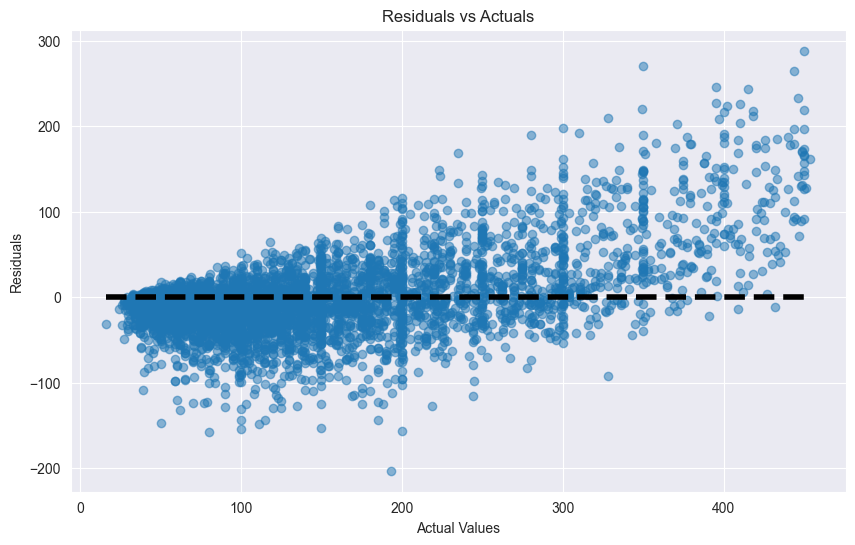

In [47]:
# Plot residuals for top-performing GBR model
ModelEvaluator.plot_residuals(y_test, gbr_preds)

The residuals plot shows that the model tended to underestimate rental prices in the upper range of values, with nearly all prices being underestimated for rentals with actual prices above $350. This is likely influenced by the distribution of prices, which skew heavily towards lower values. In future refinements to the model, this could potentially be addressed through oversampling expensive rentals, undersampling inexpensive rentals, and/or using synthetic data generation techniques like SMOTE to better balance the distribution.

Another key consideration when evaluating model performance is computational complexity. Models that are more resource-intensive to train or perform inference will generally cost more to maintain. Slow inference times can also impact the responsiveness of systems by delaying the speed at which new data can be processed and returned to the user. 

To evaluate training time, each model was trained on the 13,363 training records ten times and the average was taken to illustrate the training speed of each model. Similarly, ten iterations of inference were done, and the average time taken for inference on 1000 records was taken for each model.

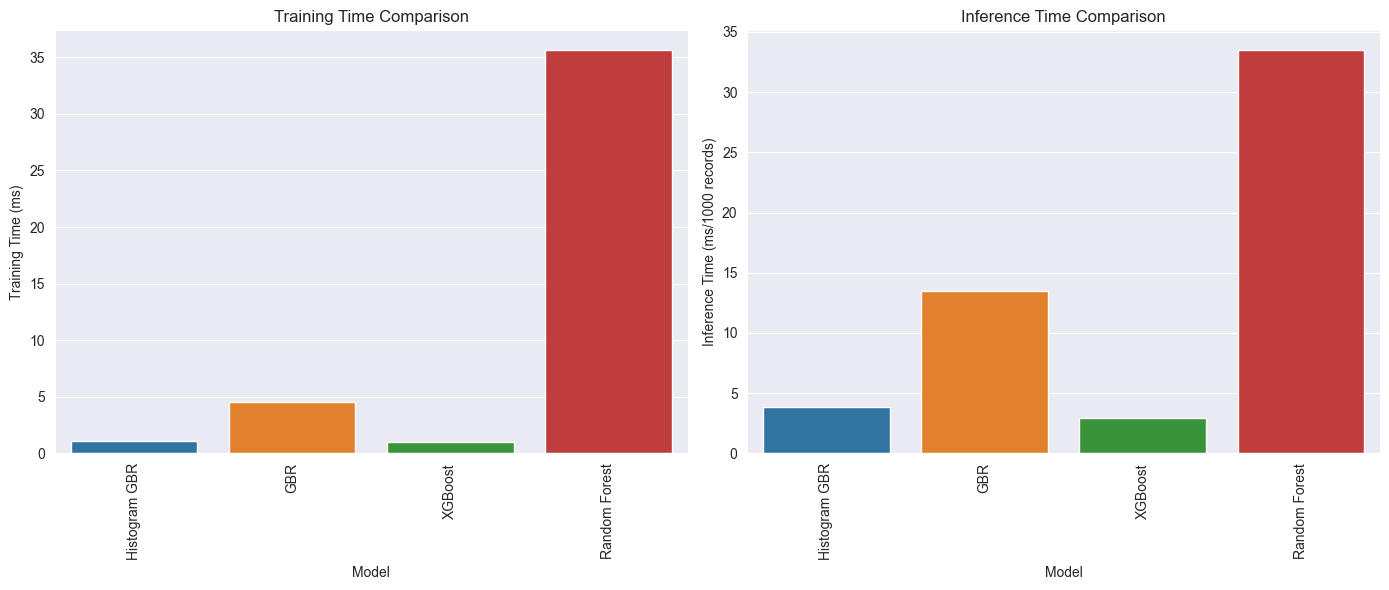

In [46]:
# Plot training and inference times for each model
model_times = pd.DataFrame({
    'Model': ['Histogram GBR', 'GBR', 'XGBoost',
                  'Random Forest'],
    'Train': [1.07, 4.525, 1.03, 35.595],
    'Inference': [3.82, 13.47, 2.92, 33.45]
})

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Model', y='Train', data=model_times, ax=ax[0], hue='Model')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title('Training Time Comparison')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Training Time (ms)')

sns.barplot(x='Model', y='Inference', data=model_times, ax=ax[1], hue='Model')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title('Inference Time Comparison')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Inference Time (ms/1000 records)')

fig.tight_layout()
plt.show()

In terms of both training and inference time, the histogram-based gradient boosting model and XGBoost model were both multiple times faster than the base gradient boosting model, with the XGBoost being the fastest by a small margin. Given the relatively small difference in accuracy between the models, this suggests that the histogram gradient boosting model also warrants consideration due to being able to perform training and inference much faster than the top-performing gradient boosting model while only performing slightly worse. 

# Deployment

The estimated price for an AirBnB only needs to be updated in a few situations:

* When a new listing is created
* When a listing is updated in a way that modifies input features
* When an estimate becomes "stale", whether that's through market changes that alter the model itself or changes to certain listing attributes over time (e.g. changes in review score)

The first two situations require real-time or near real-time calculation of the estimate, while the final situation could run on an intermittent schedule like weekly or monthly. A way to handle this is to create a service which exposes an API for updating/retrieving the model's estimate for a listing. When a listing is created or edited, the calling service could call the estimation service, which would run the listing through the model, store the result in a database, and return the result to the caller. Given the quick inference time for these models, processing a single record within the time window for an acceptable web response would not be an issue.

A larger batch job would need to be run when the model changes, or periodically to refresh estimates based on more passive data changes. This would be a much larger process as it would need to process all listings. Since each record can be processed in isolation, this would be relatively easy to distribute by allotting certain blocks of listings to different instances to be processed in parallel. These refreshed estimates would be saved to the database used by the API for consumption by web/mobile clients and/or other services.

Since updates to the estimate would be fairly rare, with reads on a listing being much more common than writes, it would be very important to implement a caching layer. This would further minimize request times and compute requirements by preventing many requests from ever hitting the API or database directly, particularly for high traffic listings.

# Discussion and conclusions – address the problem statement and recommendation.

# References and Sources

GitHub link: https://github.com/suvoganguli/AAI510_FinalProject

